<center><h2>ALTeGraD 2024<br>Lab Session 1: HAN</h2><h3>Hierarchical Attention Network Using GRU</h3> 8 / 10 / 2024<br> Dr. Guokan Shang, Yang Zhang<br><br>


<b>Student name:</b> Solal Danan


</center>
In this lab, you will get familiar with recurrent neural networks (RNNs), self-attention, and the HAN architecture <b>(Yang et al. 2016)</b> using PyTorch. In this architecture, sentence embeddings are first individually produced, and a document embedding is then computed from the sentence embeddings.<br>
<b>The deadline for this lab is October 15, 2024 11:59 PM.</b> More details about the submission and the architecture for this lab can be found in the handout PDF.


### = = = = =  Attention Layer = = = = =
In thi section, you will fill the gaps in the code to implement the self-attention layer. This layer will be used later to define the HAN architecture. The basic idea behind attention is that rather than considering the last annotation $h_T$ as a summary of the entire sequence, which is prone to information loss, the annotations at <i>all</i> time steps are used.
The self-attention mechanism computes a weighted sum of the annotations, where the weights are determined by trainable parameters. Refer to <b>section 2.2</b> in the handout for the theoretical part, it will be needed to finish the first task.

#### <b>Task 1:</b>

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader

class AttentionWithContext(nn.Module):
    """
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    """
    
    def __init__(self, input_shape, return_coefficients=False, bias=True):
        super(AttentionWithContext, self).__init__()
        self.return_coefficients = return_coefficients

        self.W = nn.Linear(input_shape, input_shape, bias=bias)
        self.tanh = nn.Tanh()
        self.u = nn.Linear(input_shape, 1, bias=False)

        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.W.weight.data.uniform_(-initrange, initrange)
        self.W.bias.data.uniform_(-initrange, initrange)
        self.u.weight.data.uniform_(-initrange, initrange)
    
    def generate_square_subsequent_mask(self, sz):
        # do not pass the mask to the next layers
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask
    
    def forward(self, x, mask=None):
        uit = self.W(x)
        uit = self.tanh(uit)
        ait = self.u(uit)
        a = torch.exp(ait)
        
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            a = a*mask.double()
        
        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        eps = 1e-9
        a = a / (torch.sum(a, axis=1, keepdim=True) + eps)
        # Compute the attentional vector: weighted sum of input x based on attention weights a
        weighted_input = torch.sum(a * x, axis=1)
        if self.return_coefficients:
            return weighted_input, a
        else:
            return weighted_input

### = = = = = Parameters = = = = =
In this section, we define the parameters to use in our training. Such as data path, the embedding dimention <b>d</b>, the GRU layer dimensionality <b>n_units</b>, etc..<br>
The parameter <b>device</b> is used to train the model on GPU if it is available. for this purpose, if you are using Google Colab, switch your runtime to a GPU runtime to train the model with a maximum speed.<br>
<b>Bonus question:</b> What is the purpose of the parameter <i>my_patience</i>?

Purpose of **my_patience** parameter : 


The my_patience = 2 parameter is used for early stopping, a technique that helps prevent overfitting during model training. The idea behind early stopping is to monitor the model’s performance on the validation set after each epoch (one full pass over the training data), if the validation performance doesn't improve for a certain number of consecutive epochs training will be stopped early. This is controlled by the my_patience parameter, which sets how many "bad" epochs are tolerated before halting.

By stopping training early, we avoid wasting time on training that doesn't lead to better results and also reduce the risk of overfitting. Overfitting happens when the model becomes too specialized to the training data and doesn’t generalize well to new data. 

However, if the model is prone to this "double dip" behavior, early stopping might cut training too soon, before the model has had the chance to reach its true optimal performance.

In [3]:
import sys
import json
import operator
import numpy as np

path_root = ''
path_to_data = path_root + 'data/'

d = 30 # dimensionality of word embeddings
n_units = 50 # RNN layer dimensionality
drop_rate = 0.5 # dropout
mfw_idx = 2 # index of the most frequent words in the dictionary 
            # 0 is for the special padding token
            # 1 is for the special out-of-vocabulary token

padding_idx = 0
oov_idx = 1
batch_size = 64
nb_epochs = 15
my_patience = 2 # `for early stopping strategy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### = = = = = Data Loading = = = = =
In this section we will use first <b>wget</b> to download the data the we will load it using numpy in the first cell. While in the second cell, we will use these data to define our Pytorch data loader. Note that the data is already preprocessed, tokenized and padded.<br><br>
<b>Note: if you are running your notebook on Windows or on MacOS, <i>wget</i> will probably not work if you did not install it manually. In this case, use the provided link to download the data and change the <i>path_to_data</i> in the <i>Parameters</i> section accordingly. Otherwise, you will face no problem on Ubuntu and Google Colab.</b>

#### <b>Task 2.1:</b>

In [4]:
import urllib.request
url = "https://onedrive.live.com/download?cid=AE69638675180117&resid=AE69638675180117%2199289&authkey=AHgxt3xmgG0Fu5A"
output_file = "data.zip"
urllib.request.urlretrieve(url, output_file)

!unzip -o data.zip

my_docs_array_train = np.load(path_to_data + 'docs_train.npy')
my_docs_array_test = np.load(path_to_data + 'docs_test.npy')

my_labels_array_train = np.load(path_to_data + 'labels_train.npy')
my_labels_array_test = np.load(path_to_data + 'labels_test.npy')

# load dictionary of word indexes (sorted by decreasing frequency across the corpus)
with open(path_to_data + 'word_to_index.json', 'r') as my_file:
    word_to_index = json.load(my_file)

# invert mapping
index_to_word = {index: word for word, index in word_to_index.items()}
input_size = my_docs_array_train.shape

Archive:  data.zip
  inflating: __MACOSX/._data         
  inflating: data/labels_train.npy   
  inflating: __MACOSX/data/._labels_train.npy  
  inflating: data/docs_test.npy      
  inflating: __MACOSX/data/._docs_test.npy  
  inflating: data/labels_test.npy    
  inflating: __MACOSX/data/._labels_test.npy  
  inflating: data/word_to_index.json  
  inflating: __MACOSX/data/._word_to_index.json  
  inflating: data/docs_train.npy     
  inflating: __MACOSX/data/._docs_train.npy  


In [7]:
print(my_docs_array_train.shape)  # Prints the shape of the array (e.g., number of documents, length of each document)
print(np.unique(my_labels_array_train))
print(my_labels_array_train.shape)  # Prints the shape of the array (e.g., number of documents, length of each document)


(25000, 7, 30)
[0 1]
(25000,)


In [5]:
import numpy
import torch
from torch.utils.data import DataLoader, Dataset


class Dataset_(Dataset):
    def __init__(self, x, y):
        self.documents = x
        self.labels = y

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index):
        document = self.documents[index]
        label = self.labels[index] 
        sample = {
            "document": torch.tensor(document),
            "label": torch.tensor(label),
            }
        return sample


def get_loader(x, y, batch_size=32):
    dataset = Dataset_(x, y)
    data_loader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            pin_memory=True,
                            drop_last=True,
                            )
    return data_loader

### = = = = = Defining Architecture = = = = =
In this section, we define the HAN architecture. We start with <i>AttentionBiGRU</i> module in order to define the sentence encoder (check Figure 3 in the handout). Then, we define the <i>TimeDistributed</i> module to allow us to forward our input (batch of document) as to the sentence encoder as <b>batch of sentences</b>, where each sentence in the document will be considered as a time step. This module also reshape the output to a batch of timesteps representations per document. Finally we define the <b>HAN</b> architecture using <i>TimeDistributed</i>, <i>AttentionWithContext</i> and <i>GRU</i>.

#### <b>Task 2.2:</b>

In [8]:

class AttentionBiGRU(nn.Module):
    def __init__(self, input_shape, n_units, index_to_word, dropout=0):
        super(AttentionBiGRU, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=len(index_to_word) + 2, # vocab size
                                      embedding_dim=d, # dimensionality of embedding space
                                      padding_idx=0  # index for padding token, ensuring that the padding doesn't affect model learning
                                      )
        self.dropout = nn.Dropout(p=drop_rate)  

        self.gru = nn.GRU(input_size=d,
                          hidden_size=n_units,
                          num_layers=1,
                          bias=True,
                          batch_first=True,
                          bidirectional=True)

        self.attention = AttentionWithContext(2 * n_units, # input size to the attention layer, which matches bidirectional GRU output (2 * n_units)
                                            return_coefficients=True
                                            )

    def forward(self, sent_ints):
        sent_wv = self.embedding(sent_ints)
        sent_wv_dr = self.dropout(sent_wv)
        sent_wa, _ = self.gru(sent_wv_dr) # RNN layer - bidirectional GRU
        sent_att_vec, word_att_coeffs = self.attention(sent_wa)  # attentional vector for the sent
        sent_att_vec_dr = self.dropout(sent_att_vec)     
        return sent_att_vec_dr, word_att_coeffs


class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):
        if len(x.size()) <= 2:
            return self.module(x)
        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size) (448, 30)
        sent_att_vec_dr, word_att_coeffs = self.module(x_reshape)
        # We have to reshape the output
        if self.batch_first:
            sent_att_vec_dr = sent_att_vec_dr.contiguous().view(x.size(0), -1, sent_att_vec_dr.size(-1))  # (samples, timesteps, output_size)
            word_att_coeffs = word_att_coeffs.contiguous().view(x.size(0), -1, word_att_coeffs.size(-1))  # (samples, timesteps, output_size)
        else:
            sent_att_vec_dr = sent_att_vec_dr.view(-1, x.size(1), sent_att_vec_dr.size(-1))  # (timesteps, samples, output_size)
            word_att_coeffs = word_att_coeffs.view(-1, x.size(1), word_att_coeffs.size(-1))  # (timesteps, samples, output_size)
        return sent_att_vec_dr, word_att_coeffs      

class HAN(nn.Module):
    def __init__(self, input_shape, n_units, index_to_word, dropout=0):
        super(HAN, self).__init__()
        self.encoder = AttentionBiGRU(input_shape, n_units, index_to_word, dropout)
        self.timeDistributed = TimeDistributed(self.encoder, True)
        self.dropout = nn.Dropout(p=drop_rate)
        self.gru = nn.GRU(input_size=2 * n_units, # the input shape of GRU layer
                          hidden_size=n_units,
                          num_layers=1,
                          bias=True,
                          batch_first=True,
                          bidirectional=True)
        self.attention = AttentionWithContext(2 * n_units, # the input shape of between-sentence attention layer
                                              return_coefficients=True)

        self.lin_out = nn.Linear(in_features=2 * n_units,    # input to the linear layer is the document vector 
                                 out_features=1)            # output size is 1 for binary classification
        
        self.preds = nn.Sigmoid()

    def forward(self, doc_ints):
        sent_att_vecs_dr, word_att_coeffs =  self.timeDistributed(doc_ints) # get sentence representation by applying the encoder across sentences
        doc_sa, _ = self.gru(sent_att_vecs_dr)
        doc_att_vec, sent_att_coeffs = self.attention(doc_sa)
        doc_att_vec_dr = self.dropout(doc_att_vec)
        doc_att_vec_dr = self.lin_out(doc_att_vec_dr)          # pass through the linear layer to get the final prediction
        return self.preds(doc_att_vec_dr), word_att_coeffs, sent_att_coeffs    # apply sigmoid to get probabilities for binary classification



### = = = = = Training = = = = =
In this section, we have two code cells. In the first one, we define our evaluation function to compute the training and validation accuracies. While in the second one, we define our model, loss and optimizer and train the model over <i>nb_epochs</i>.<br>
<b>Bonus task:</b> use <a href="https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html" target="_blank">tensorboard</a> to visualize the loss and the validation accuray during the training.

#### <b>Task 2.3:</b>

In [9]:
def evaluate_accuracy(data_loader, verbose=True):
    model.eval()
    total_loss = 0.0
    ncorrect = ntotal = 0
    with torch.no_grad():
        for idx, data in enumerate(data_loader):
            # inference 
            output = model(data["document"].to(device))[0] 
            output = output[:, -1] # only last vector
            # total number of examples
            ntotal +=  output.shape[0]
            # number of correct predictions 
            predictions = torch.round(output)
            ncorrect += torch.sum(predictions == data["label"].to(device))
        acc = ncorrect.item() / ntotal
        if verbose:
          print("validation accuracy: {:3.2f}".format(acc*100))
        return acc

In [8]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

# Initialize TensorBoard writer
writer = SummaryWriter()


model = HAN(input_size, n_units, index_to_word).to(device)
model = model.double()
lr = 0.001  # learning rate
criterion = torch.nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def train(x_train=my_docs_array_train,
          y_train=my_labels_array_train,
          x_test=my_docs_array_test,
          y_test=my_labels_array_test,
          word_dict=index_to_word,
          batch_size=batch_size):
  
    train_data = get_loader(x_train, y_train, batch_size)
    test_data = get_loader(my_docs_array_test, my_labels_array_test, batch_size)

    best_validation_acc = 0.0
    p = 0 # patience

    for epoch in range(1, nb_epochs + 1): 
        losses = []
        accuracies = []
        with tqdm(train_data, unit="batch") as tepoch:
            for idx, data in enumerate(tepoch):
                tepoch.set_description(f"Epoch {epoch}")
                model.train()
                optimizer.zero_grad()
                input = data['document'].to(device)
                label = data['label'].to(device)
                label = label.double()
                output = model.forward(input)[0]
                output = output[:, -1]
                loss = criterion(output, label)      # Binary Cross Entropy Loss
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # prevent exploding gradient 
                optimizer.step()

                losses.append(loss.item())
                accuracy = torch.sum(torch.round(output) == label).item() / batch_size
                accuracies.append(accuracy)
                tepoch.set_postfix(loss=sum(losses)/len(losses), accuracy=100. * sum(accuracies)/len(accuracies))

                # Log the loss and accuracy to TensorBoard (per batch)
                writer.add_scalar('Loss/train', loss.item(), epoch * len(train_data) + idx)
                writer.add_scalar('Accuracy/train', accuracy, epoch * len(train_data) + idx)


        # train_acc = evaluate_accuracy(train_data, False)
        test_acc = evaluate_accuracy(test_data, False)

        print("===> Epoch {} Complete: Avg. Loss: {:.4f}, Validation Accuracy: {:3.2f}%"
              .format(epoch, sum(losses)/len(losses), 100.*test_acc))
        if test_acc >= best_validation_acc:
            best_validation_acc = test_acc
            print("Validation accuracy improved, saving model...")
            torch.save(model.state_dict(), './best_model.pt')
            p = 0
            print()
        else:
            p += 1
            if p==my_patience:
                print("Validation accuracy did not improve for {} epochs, stopping training...".format(my_patience))
    print("Loading best checkpoint...")    
    model.load_state_dict(torch.load('./best_model.pt'))
    model.eval()
    print('done.')

train()
writer.close()

Epoch 1: 100%|██████████| 390/390 [01:06<00:00,  5.83batch/s, accuracy=58.8, loss=0.664]


===> Epoch 1 Complete: Avg. Loss: 0.6640, Validation Accuracy: 69.75%
Validation accuracy improved, saving model...



Epoch 2: 100%|██████████| 390/390 [01:01<00:00,  6.34batch/s, accuracy=70.9, loss=0.568]


===> Epoch 2 Complete: Avg. Loss: 0.5682, Validation Accuracy: 75.99%
Validation accuracy improved, saving model...



Epoch 3: 100%|██████████| 390/390 [01:02<00:00,  6.21batch/s, accuracy=75.8, loss=0.5]  


===> Epoch 3 Complete: Avg. Loss: 0.4996, Validation Accuracy: 78.25%
Validation accuracy improved, saving model...



Epoch 4: 100%|██████████| 390/390 [01:04<00:00,  6.07batch/s, accuracy=78.5, loss=0.458]


===> Epoch 4 Complete: Avg. Loss: 0.4576, Validation Accuracy: 80.81%
Validation accuracy improved, saving model...



Epoch 5: 100%|██████████| 390/390 [01:03<00:00,  6.15batch/s, accuracy=80.6, loss=0.421]


===> Epoch 5 Complete: Avg. Loss: 0.4215, Validation Accuracy: 81.95%
Validation accuracy improved, saving model...



Epoch 6: 100%|██████████| 390/390 [01:06<00:00,  5.85batch/s, accuracy=82.2, loss=0.395]


===> Epoch 6 Complete: Avg. Loss: 0.3949, Validation Accuracy: 82.79%
Validation accuracy improved, saving model...



Epoch 7: 100%|██████████| 390/390 [01:05<00:00,  5.95batch/s, accuracy=83.6, loss=0.371]


===> Epoch 7 Complete: Avg. Loss: 0.3710, Validation Accuracy: 81.89%


Epoch 8: 100%|██████████| 390/390 [01:04<00:00,  6.04batch/s, accuracy=84.4, loss=0.36] 


===> Epoch 8 Complete: Avg. Loss: 0.3595, Validation Accuracy: 83.84%
Validation accuracy improved, saving model...



Epoch 9: 100%|██████████| 390/390 [01:05<00:00,  5.94batch/s, accuracy=85.6, loss=0.341]


===> Epoch 9 Complete: Avg. Loss: 0.3406, Validation Accuracy: 82.71%


Epoch 10: 100%|██████████| 390/390 [01:04<00:00,  6.04batch/s, accuracy=86, loss=0.323]  


===> Epoch 10 Complete: Avg. Loss: 0.3234, Validation Accuracy: 84.41%
Validation accuracy improved, saving model...



Epoch 11: 100%|██████████| 390/390 [01:06<00:00,  5.87batch/s, accuracy=86.8, loss=0.312]


===> Epoch 11 Complete: Avg. Loss: 0.3118, Validation Accuracy: 84.67%
Validation accuracy improved, saving model...



Epoch 12: 100%|██████████| 390/390 [01:04<00:00,  6.01batch/s, accuracy=87.3, loss=0.296]


===> Epoch 12 Complete: Avg. Loss: 0.2962, Validation Accuracy: 84.94%
Validation accuracy improved, saving model...



Epoch 13: 100%|██████████| 390/390 [01:05<00:00,  5.95batch/s, accuracy=87.6, loss=0.291]


===> Epoch 13 Complete: Avg. Loss: 0.2912, Validation Accuracy: 84.94%


Epoch 14: 100%|██████████| 390/390 [01:04<00:00,  6.03batch/s, accuracy=88.2, loss=0.279]


===> Epoch 14 Complete: Avg. Loss: 0.2786, Validation Accuracy: 84.99%
Validation accuracy improved, saving model...



Epoch 15: 100%|██████████| 390/390 [01:05<00:00,  5.93batch/s, accuracy=89.2, loss=0.264]


===> Epoch 15 Complete: Avg. Loss: 0.2639, Validation Accuracy: 85.04%
Validation accuracy improved, saving model...

Loading best checkpoint...
done.


/var/folders/cg/ltgc1bw91_q800mfcy5vfvkw0000gn/T/ipykernel_32287/878924082.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./best_mode

In [9]:
!tensorboard --logdir=runs

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.17.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C


Accessing the link http://localhost:6007/ helps to visualize the training and loss and accuracy in real-time as the model trains. These visualizations allow to track how well the model is learning, spot potential issues like overfitting, and monitor progress as it evolves over multiple epochs.


### = = = = = Extraction of Attention Coefficients = = = = =
In this section, we will extract and display the attention coefficients on two levels: sentence level and word level. To do so, we will extract the corresponding weights from our model.
#### <b>Task 3:</b>

In [10]:
# select last review:
my_review = my_docs_array_test[-1:,:,:]
 
# convert integer review to text:
index_to_word[1] = 'OOV'
my_review_text = [[index_to_word[idx] for idx in sent if idx in index_to_word] for sent in my_review.tolist()[0]]

###   &emsp;&emsp;  = = = = = Attention Over Sentences in the Document = = = = =

In [15]:
my_review_tensor = torch.tensor(my_review).to(device)  # convert the review to a tensor
sent_coeffs = model(my_review_tensor)[2]  # get sentence-level attention coefficients (third return value) by passing the review to the model
sent_coeffs = sent_coeffs[0,:,:]  # attention coefficients are of shape [1, num_sentences, 1], so we need to squeeze it

for elt in zip(sent_coeffs[:,0].tolist(),[' '.join(elt) for elt in my_review_text]):
    print(round(elt[0]*100,2),elt[1])

6.53 There 's a sign on The Lost Highway that says : OOV SPOILERS OOV ( but you already knew that , did n't you ? )
9.28 Since there 's a great deal of people that apparently did not get the point of this movie , I 'd like to contribute my interpretation of why the plot
8.84 As others have pointed out , one single viewing of this movie is not sufficient .
10.1 If you have the DVD of MD , you can OOV ' by looking at David Lynch 's 'Top 10 OOV to OOV MD ' ( but only upon second
19.87 ; ) First of all , Mulholland Drive is downright brilliant .
28.1 A masterpiece .
17.29 This is the kind of movie that refuse to leave your head .


### &emsp;&emsp; = = = = = Attention Over Words in Each Sentence = = = = =

In [25]:
word_coeffs = model(my_review_tensor)[1] # get words attention coeffs by passing the review to the model - (you need to convert the inout torch tensor)

word_coeffs_list = word_coeffs.reshape(7,30).tolist()

# match text and coefficients:
text_word_coeffs = [list(zip(words,word_coeffs_list[idx][:len(words)])) for idx,words in enumerate(my_review_text)]

for sent in text_word_coeffs:
    [print(elt) for elt in sent]
    print('= = = =')

# sort words by importance within each sentence:
text_word_coeffs_sorted = [sorted(elt,key=operator.itemgetter(1),reverse=True) for elt in text_word_coeffs]


for sent in text_word_coeffs_sorted:
    [print(elt) for elt in sent]
    print('= = = =')

('There', 0.059800881382496576)
("'s", 0.04508108061556802)
('a', 0.03258099199463055)
('sign', 0.04401461062126096)
('on', 0.02299609152927782)
('The', 0.03971352872404635)
('Lost', 0.06672400871180785)
('Highway', 0.027094870332162364)
('that', 0.02682022489098598)
('says', 0.018764854600031255)
(':', 0.021727725015965666)
('OOV', 0.02087754077317332)
('SPOILERS', 0.026106893186273353)
('OOV', 0.01966605629436334)
('(', 0.017952638147304606)
('but', 0.020078465801665873)
('you', 0.039457662669184206)
('already', 0.09497431690555494)
('knew', 0.0642015626078418)
('that', 0.0542332903463517)
(',', 0.026915475471807226)
('did', 0.021540266200161657)
("n't", 0.026344406932502503)
('you', 0.02778464600166873)
('?', 0.03304733691650608)
(')', 0.02263824529678238)
= = = =
('Since', 0.028216958865685867)
('there', 0.04678956556030554)
("'s", 0.030147773101540955)
('a', 0.02327438282122043)
('great', 0.13906765865273282)
('deal', 0.06512293480708002)
('of', 0.049173938578686016)
('people', 0.

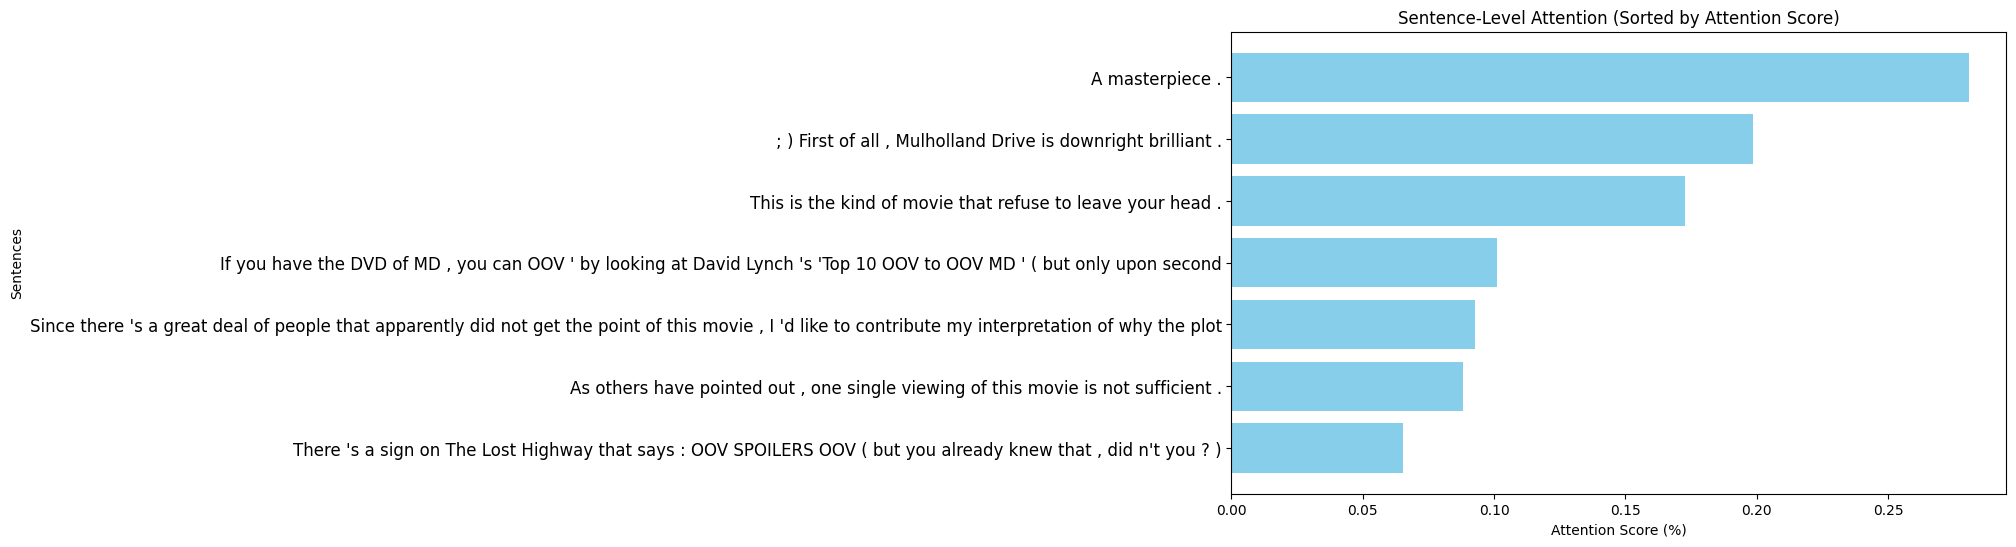

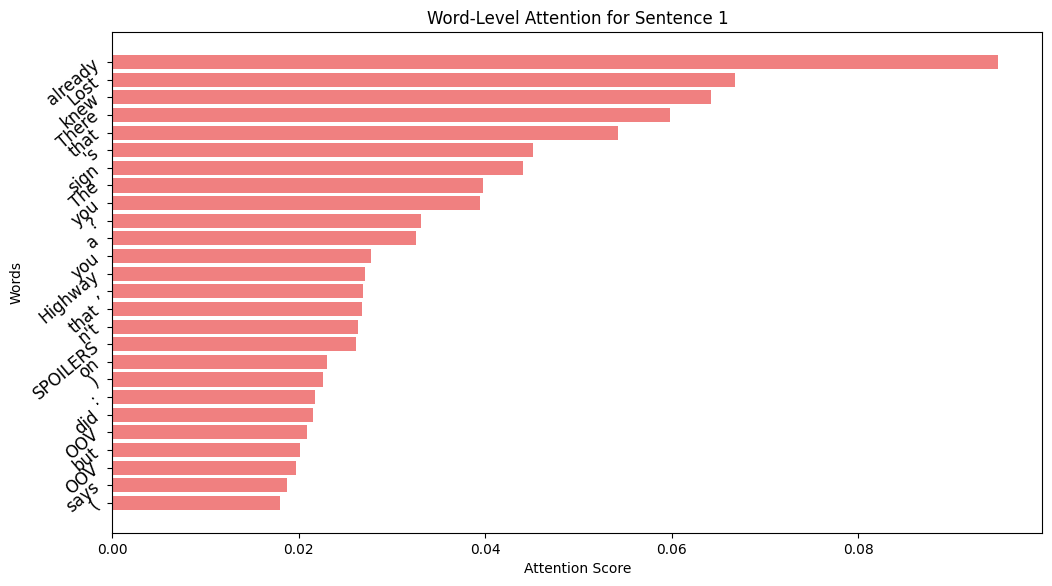

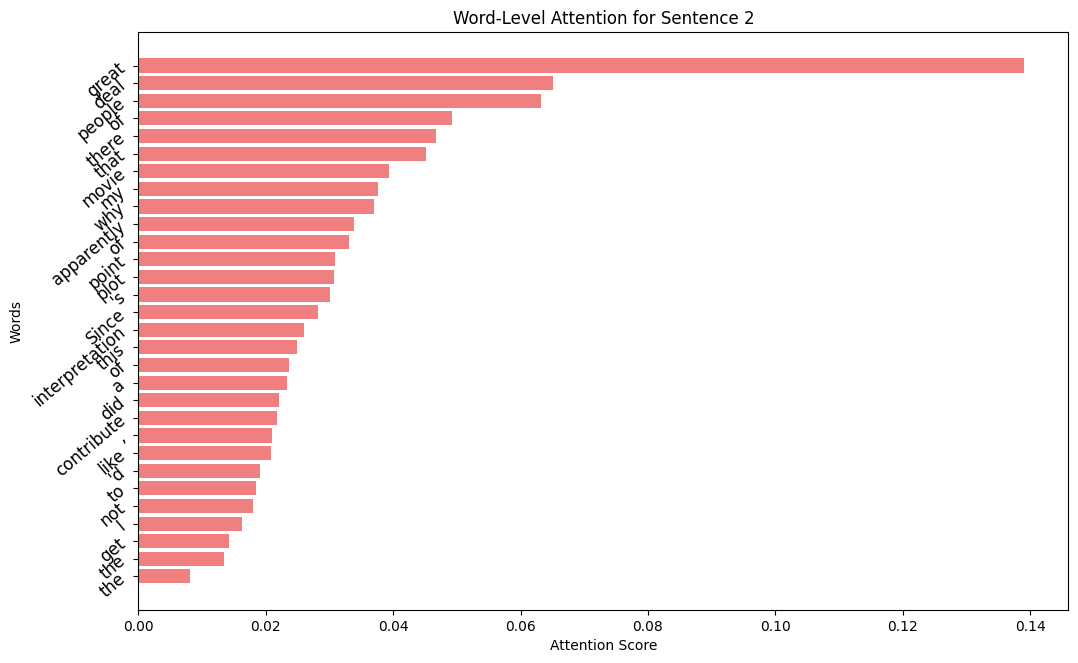

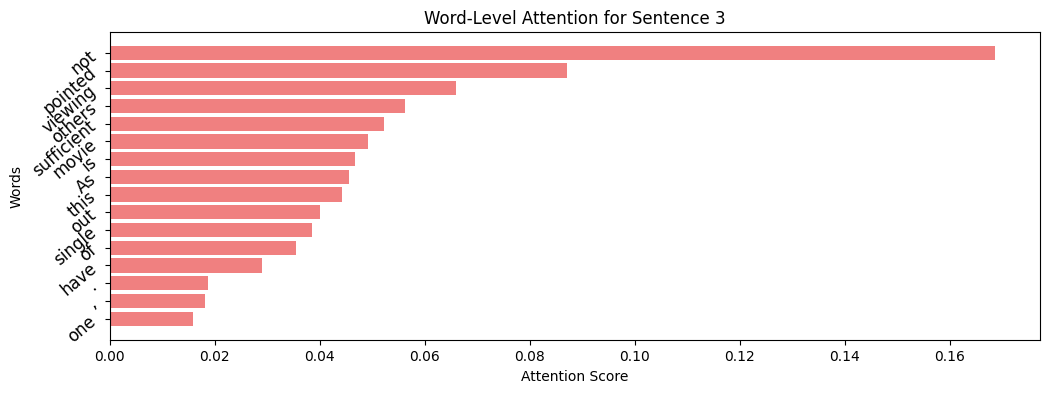

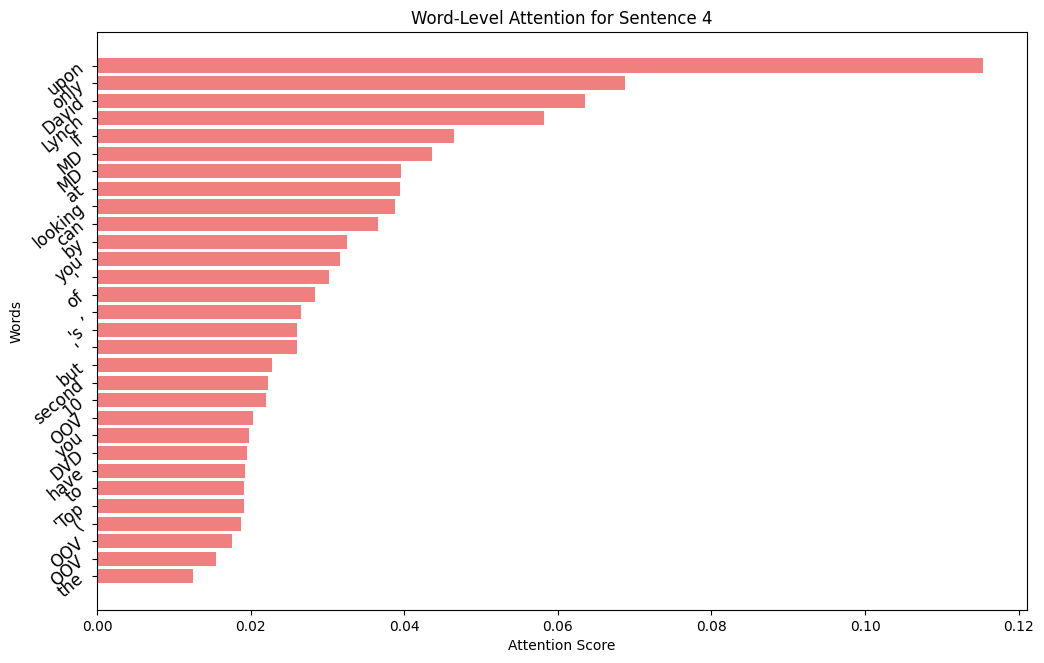

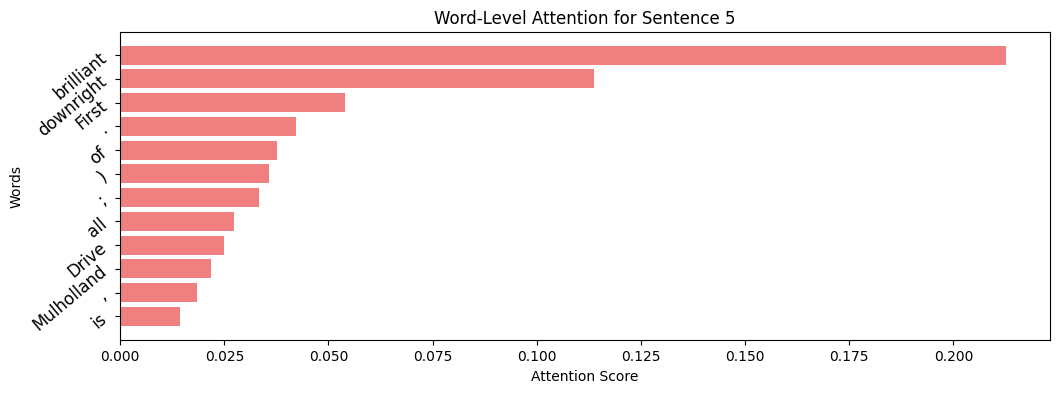

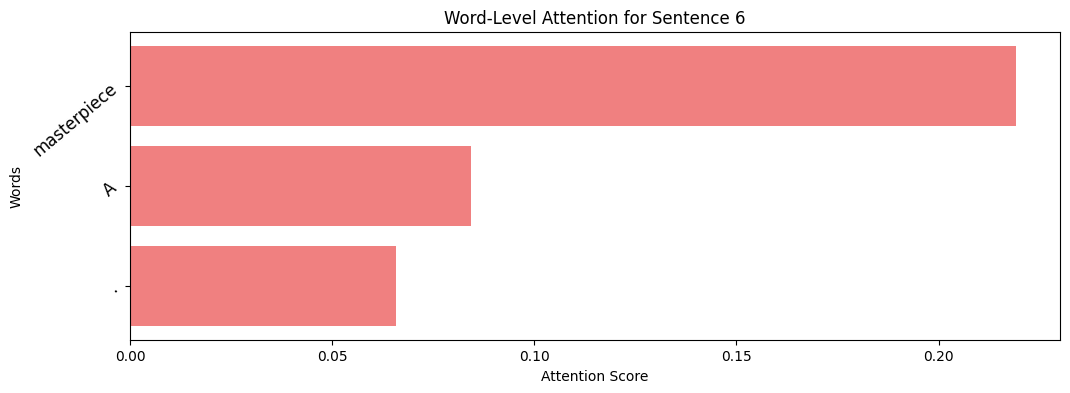

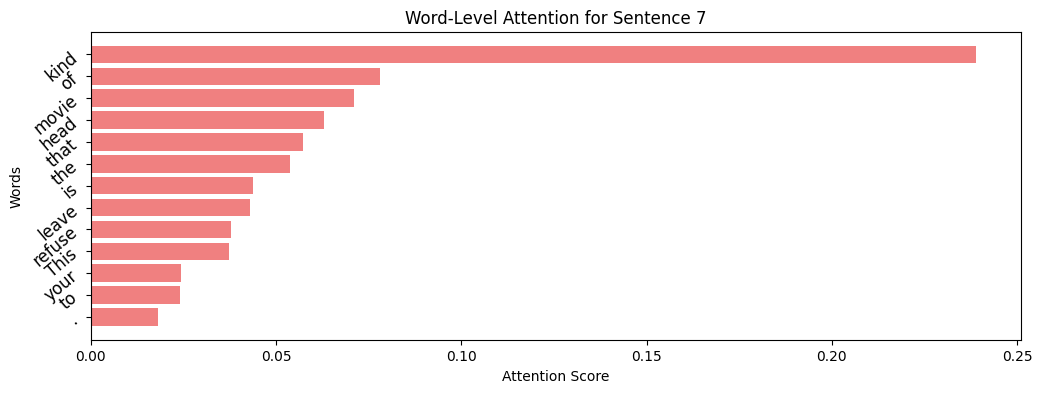

In [46]:
import matplotlib.pyplot as plt


# Plot Sentence-Level Attention Coefficients, sorted by attention score
def plot_sentence_attention(sent_coeffs, review_text):
    sentences = [' '.join(sent) for sent in review_text]
    attention_scores = sent_coeffs[:, 0].tolist()
    sorted_sentences_and_scores = sorted(zip(sentences, attention_scores), key=lambda x: x[1], reverse=True)
    sorted_sentences, sorted_scores = zip(*sorted_sentences_and_scores)
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_sentences)), sorted_scores, color='skyblue')
    plt.yticks(range(len(sorted_sentences)), sorted_sentences, fontsize=12)
    plt.xlabel('Attention Score (%)')
    plt.ylabel('Sentences')
    plt.title('Sentence-Level Attention (Sorted by Attention Score)')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest attention on top
    plt.show()


# Plot Word-Level Attention Coefficients for each sentence
def plot_word_attention(word_coeffs, review_text):
    for i, (words, word_att) in enumerate(zip(review_text, word_coeffs)):
        sorted_word_att = sorted(zip(words, [att for _, att in word_att]), key=lambda x: x[1], reverse=True)
        words_sorted = [w for w, _ in sorted_word_att]
        scores_sorted = [att for _, att in sorted_word_att]
        plt.figure(figsize=(12, max(len(words_sorted)*0.25, 4) )) 
        plt.barh(range(len(words_sorted)), scores_sorted, color='lightcoral')
        plt.yticks(range(len(words_sorted)), words_sorted, fontsize=12, rotation=40)
        plt.xlabel('Attention Score')
        plt.ylabel('Words')
        plt.title(f'Word-Level Attention for Sentence {i+1}')
        plt.gca().invert_yaxis()
        plt.show()

plot_sentence_attention(sent_coeffs, my_review_text)
plot_word_attention(text_word_coeffs, my_review_text) 
